copied from: https://medium.com/@geonextgis/getting-started-with-microsoft-planetary-computer-stac-api-67cbebe96e5e

In [174]:
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt
import geopandas as gpd
from pystac.extensions.eo import EOExtension as eo

In [80]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace
)


In [87]:
# from original example
# bbox_of_interest = [77.3521, 12.7235, 77.8477, 13.2186]
# time_of_interest = "2022-01-01/2022-12-31"

# FHL location on San Juans
bbox_of_interest = [-123.33711789011167, 48.30270109018668, -122.65866282644907, 48.93242519875351]

time_of_interest = "2022-07-26/2022-07-28"

In [88]:
# Query the catalog and sort the filtered image collection based on 'cloud_cover' 
search = catalog.search(
    collections=["landsat-c2-l2", "landsat-c1-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    # query={"eo:cloud_cover": {"lt": 10}},
    # sortby=["eo:cloud_cover"]
)

items = search.item_collection()
print(f"Returned {len(items)} Items")


Returned 6 Items


In [89]:
for item in items:
    print(item)

<Item id=LC08_L2SP_046027_20220728_02_T1>
<Item id=LC08_L2SP_046026_20220728_02_T1>
<Item id=LC09_L2SP_047027_20220727_02_T1>
<Item id=LC09_L2SP_047026_20220727_02_T1>
<Item id=LC08_L2SP_048026_20220726_02_T1>
<Item id=LE07_L2SP_048026_20220726_02_T1>


In [90]:
# Take the first item with minimum cloud cover
selected_item = items[5] 

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f"with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LE07_L2SP_048026_20220726_02_T1 from 2022-07-26with 0.0% cloud cover


In [93]:
for selected_item in items:
    for key, asset in selected_item.assets.items():
        print(f"{key}: {asset.title}")
    print()


qa: Surface Temperature Quality Assessment Band
ang: Angle Coefficients File
red: Red Band
blue: Blue Band
drad: Downwelled Radiance Band
emis: Emissivity Band
emsd: Emissivity Standard Deviation Band
trad: Thermal Radiance Band
urad: Upwelled Radiance Band
atran: Atmospheric Transmittance Band
cdist: Cloud Distance Band
green: Green Band
nir08: Near Infrared Band 0.8
lwir11: Surface Temperature Band
swir16: Short-wave Infrared Band 1.6
swir22: Short-wave Infrared Band 2.2
coastal: Coastal/Aerosol Band
mtl.txt: Product Metadata File (txt)
mtl.xml: Product Metadata File (xml)
mtl.json: Product Metadata File (json)
qa_pixel: Pixel Quality Assessment Band
qa_radsat: Radiometric Saturation and Terrain Occlusion Quality Assessment Band
qa_aerosol: Aerosol Quality Assessment Band
tilejson: TileJSON with default rendering
rendered_preview: Rendered preview

qa: Surface Temperature Quality Assessment Band
ang: Angle Coefficients File
red: Red Band
blue: Blue Band
drad: Downwelled Radiance Band

In [46]:
bands_of_interest = ["nir08", "red", "green", "blue", "qa_pixel", "lwir11"]
data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=bbox_of_interest
).isel(time=0)
data

<xarray.Dataset> Size: 1GB
Dimensions:      (y: 11164, x: 7604)
Coordinates:
  * y            (y) float64 89kB 5.541e+06 5.541e+06 ... 5.206e+06 5.206e+06
  * x            (x) float64 61kB 4.24e+05 4.24e+05 ... 6.52e+05 6.52e+05
    spatial_ref  int32 4B 32610
    time         datetime64[ns] 8B 2022-07-27T19:01:26.703735
Data variables:
    nir08        (y, x) uint16 170MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    red          (y, x) uint16 170MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    green        (y, x) uint16 170MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    blue         (y, x) uint16 170MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    qa_pixel     (y, x) uint16 170MB 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    lwir11       (y, x) uint16 170MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

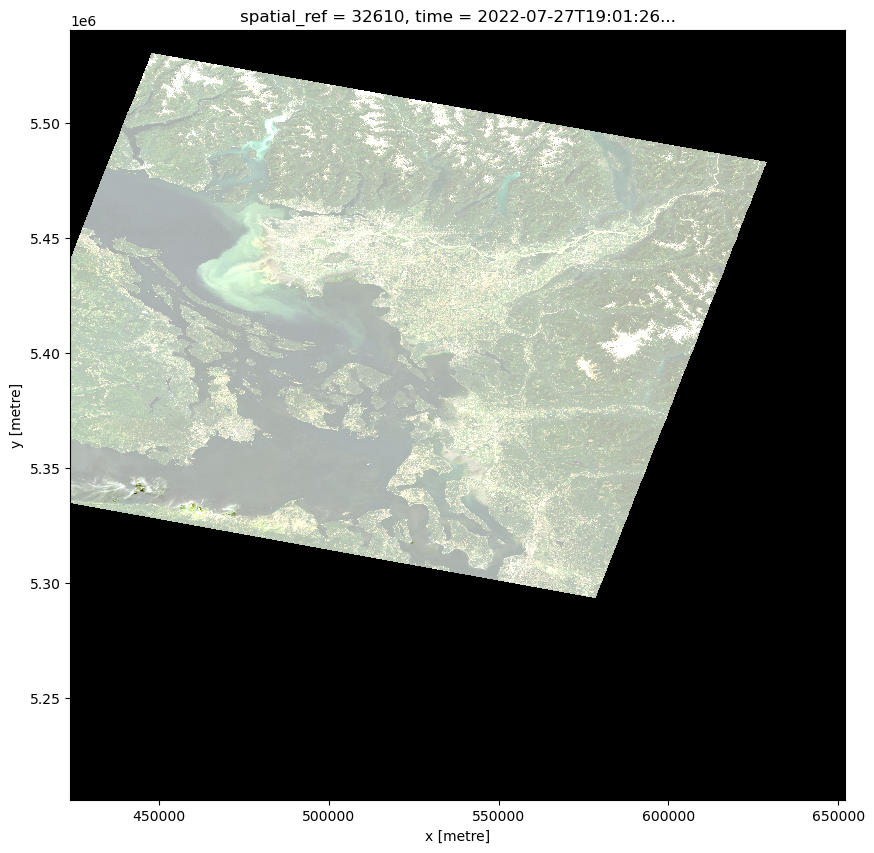

In [47]:
rgb_data_array = data[["red", "green", "blue"]].to_array()

fig, ax = plt.subplots(figsize=(10, 10))
rgb_data_array.plot.imshow(robust=True, ax=ax)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..60650].


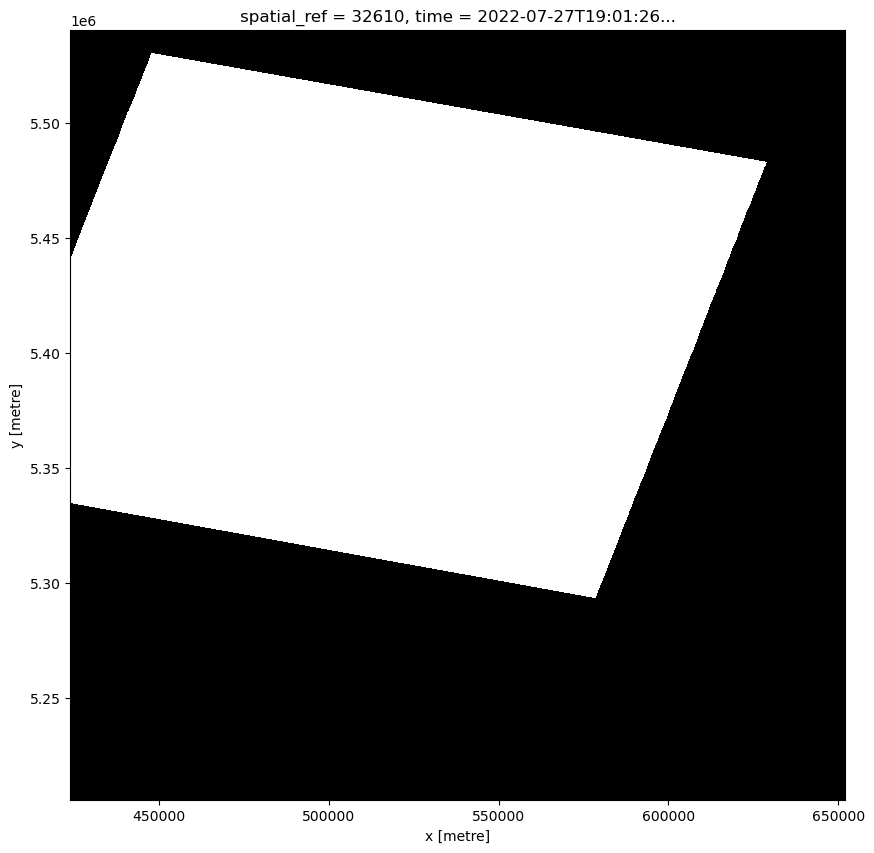

In [48]:
sfcc_data_array = data[["nir08", "red", "green"]].to_array()

fig, ax = plt.subplots(figsize=(10, 10))
sfcc_data_array.plot.imshow(
    # robust=True, 
    ax=ax
)
# ax.set_title("Standard÷ False Color, Bengaluru, Karnataka, India");

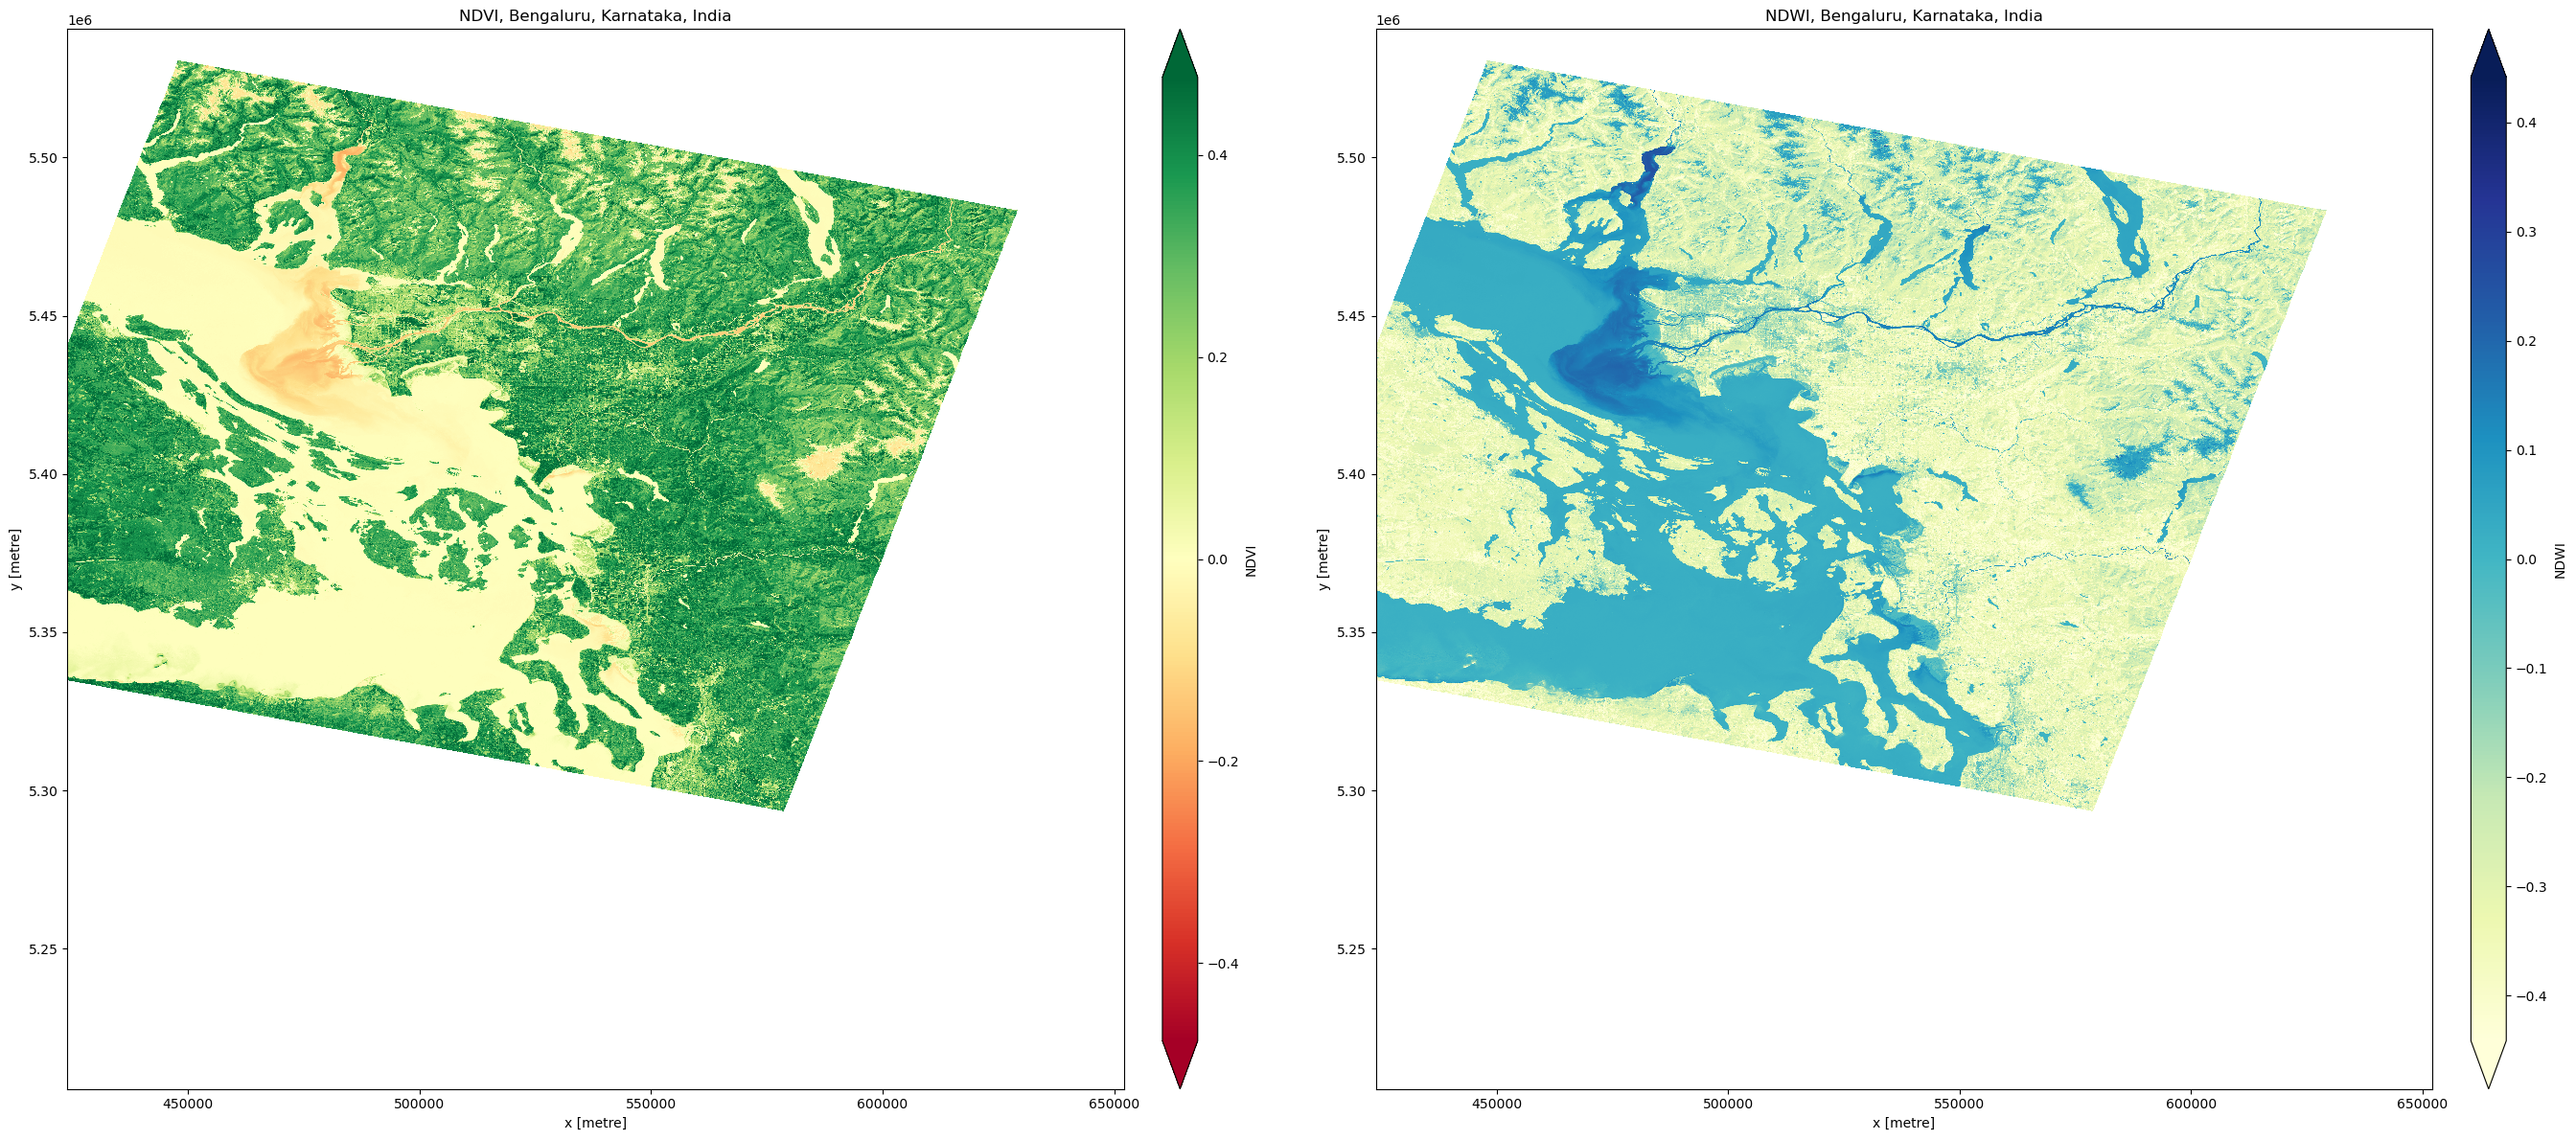

In [49]:
green = data["green"].astype("float")
red = data["red"].astype("float")
nir = data["nir08"].astype("float")

ndvi = (nir - red) / (nir + red)
ndwi = (green - nir) / (green + nir)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 12))
axes = axes.flatten()

ndvi.plot.imshow(ax=axes[0], robust=True, cmap="RdYlGn", add_colorbar=True, cbar_kwargs={"aspect": 30, "pad": 0.03, "label": "NDVI"})
axes[0].set_title("NDVI, Bengaluru, Karnataka, India");

ndwi.plot.imshow(ax=axes[1], robust=True, cmap="YlGnBu", add_colorbar=True, cbar_kwargs={"aspect": 30, "pad": 0.03, "label": "NDWI"})
axes[1].set_title("NDWI, Bengaluru, Karnataka, India");

plt.tight_layout()

In [50]:
catalog.get_collection("landsat-c2-l2").summaries.to_dict()["platform"]

['landsat-4', 'landsat-5', 'landsat-7', 'landsat-8', 'landsat-9']

In [51]:
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={
        "eo:cloud_cover": {"lt": 10},
        "platform": {"in": ['landsat-8', 'landsat-9']}
    },
    sortby=["eo:cloud_cover"]
)

items = search.item_collection()


In [53]:
for it in items:
    print(it)

<Item id=LC08_L2SP_048026_20220726_02_T1>
<Item id=LC08_L2SP_046027_20220728_02_T1>
<Item id=LC08_L2SP_046026_20220728_02_T1>
<Item id=LC08_L2SP_046025_20220728_02_T1>
<Item id=LC09_L2SP_047026_20220727_02_T1>
<Item id=LC08_L2SP_046028_20220728_02_T1>
<Item id=LC09_L2SP_047025_20220727_02_T1>
<Item id=LC08_L2SP_048025_20220726_02_T1>


In [16]:
band_info = selected_item.assets["lwir11"].extra_fields["raster:bands"][0]
band_info

{'unit': 'kelvin',
 'scale': 0.00341802,
 'nodata': 0,
 'offset': 149.0,
 'data_type': 'uint16',
 'spatial_resolution': 30}

In [55]:
temperature = data["lwir11"].astype("float")
temperature *= band_info["scale"]
temperature += band_info["offset"]
# temperature

In [58]:
celcius.min()

<xarray.DataArray 'lwir11' ()> Size: 8B
array(-124.15)
Coordinates:
    spatial_ref  int32 4B 32610
    time         datetime64[ns] 8B 2022-07-27T19:01:26.703735

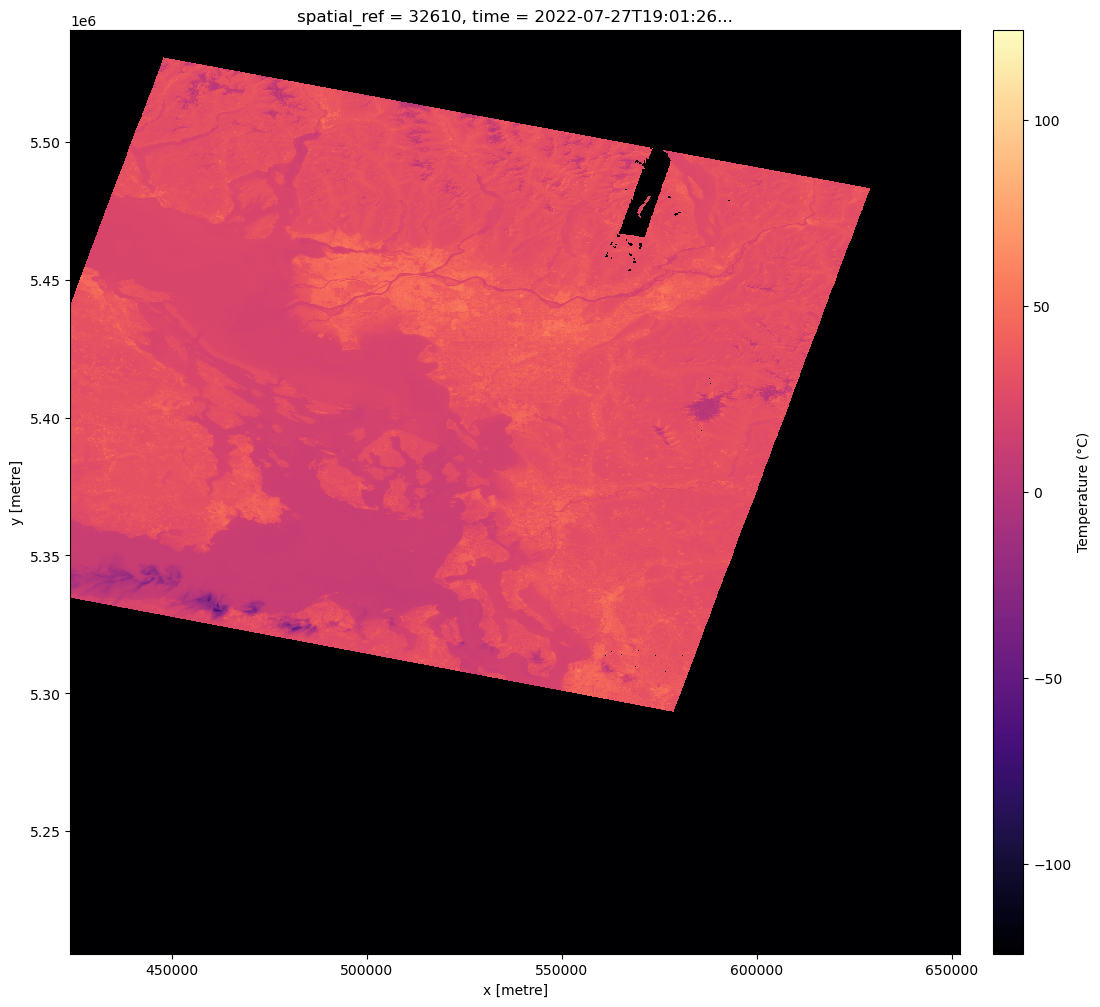

In [59]:
celcius = temperature - 273.15

plt.figure(figsize=(14, 12))
celcius.plot.imshow(cmap="magma", robust=True, cbar_kwargs={"aspect": 30, "pad": 0.03, "label": "Temperature (°C)"})
# plt.title("Thermal, Bengaluru, Karnataka, India");

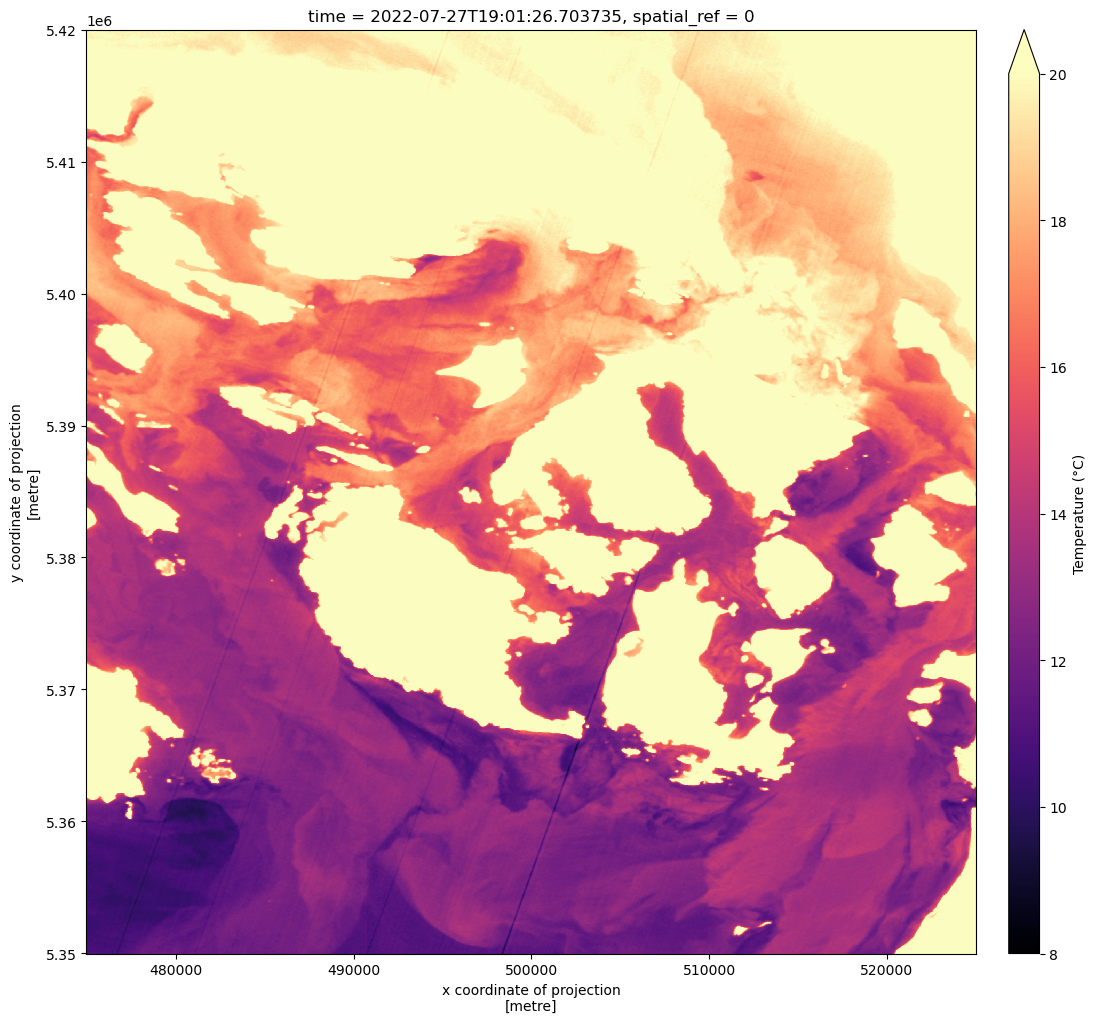

In [74]:
plt.figure(figsize=(14, 12))
celcius.rio.clip_box(
    minx = 475000,
    miny = 5350000,
    maxx = 525000,
    maxy = 5420000,
).plot.imshow(cmap="magma", robust=True, cbar_kwargs={"aspect": 30, "pad": 0.03, "label": "Temperature (°C)"}, vmin=8, vmax=20)

In [102]:
celcius.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]')

In [135]:
shorelines = gpd.read_file('ShoreZone_Inventory_-_Shoreline_type.geojson').to_crs('EPSG:32610')

In [141]:
celcius_clipped_sanjuan = celcius.rio.clip_box(
    minx = 485000,
    miny = 5365000,
    maxx = 505000,
    maxy = 5390000,
)

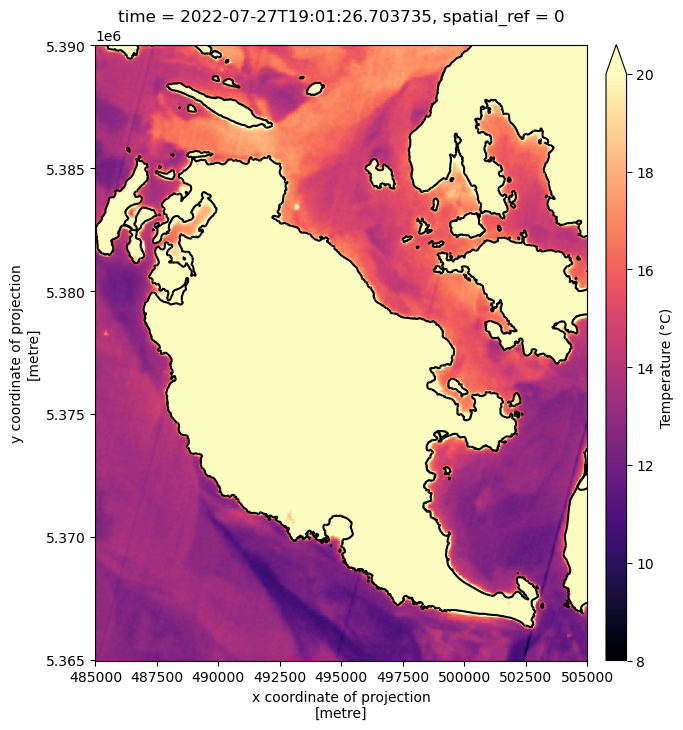

In [173]:
import matplotlib.pyplot as plt
from shapely.geometry import box
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')
celcius_clipped_sanjuan.plot.imshow(cmap="magma", robust=True, cbar_kwargs={"aspect": 30, "pad": 0.03, "label": "Temperature (°C)"}, vmin=8, vmax=20)
gpd.clip(
    shorelines,
    mask = box(*celcius_clipped_sanjuan.rio.bounds())
).plot(ax=ax, color='black', linestyle='-')
plt.show()

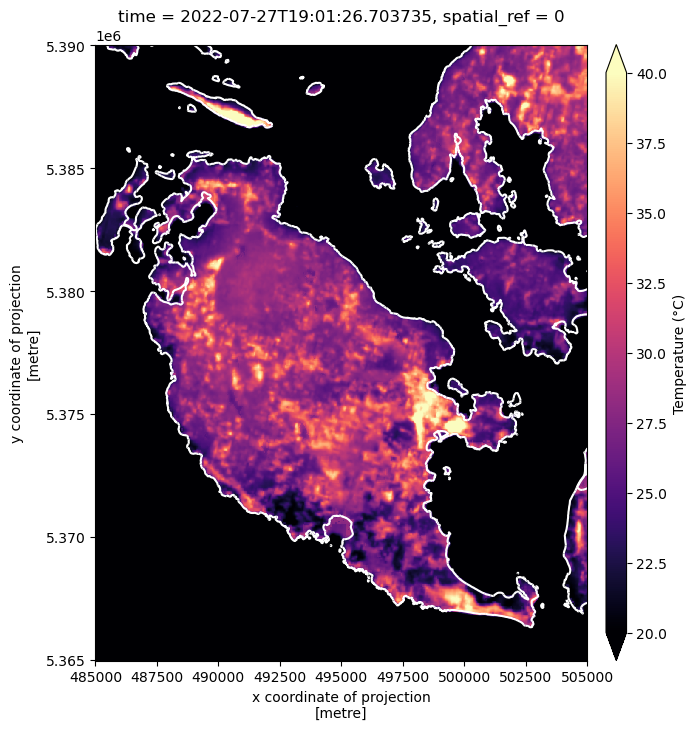

In [171]:
import matplotlib.pyplot as plt
from shapely.geometry import box
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')
celcius_clipped_sanjuan.plot.imshow(cmap="magma", robust=True, cbar_kwargs={"aspect": 30, "pad": 0.03, "label": "Temperature (°C)"}, vmin=20, vmax=40)
gpd.clip(
    shorelines,
    mask = box(*celcius_clipped_sanjuan.rio.bounds())
).plot(ax=ax, color='white', linestyle='-')
plt.show()

In [ ]:
catalog = Catalog()

begin = datetime(2022, 7, 27)
end = datetime(2020, 7, 27)
geom = Point(-123.012986, 48.546368) # point on FHL campus